In [55]:
import collections
import math
import os
import zipfile
import random
from six.moves import urllib
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

# 1. Download the text and make corpus (set of words)
## Download (or reuse) the text file  

In [8]:
folder_dir = 'data'
file_name = 'text8.zip'
file_path = os.path.join(folder_dir, file_name)
url = 'http://mattmahoney.net/dc/'

if not os.path.exists(file_path):
    print('No file found. Start downloading!!!')
    downfilename, _ = urllib.request.urlretrieve(url + file_name, file_path)
    print('%s downloaded.' % downfilename)
else:
    print('File already exists')

File already exists


## Check we have correct data

In [7]:
stat_info = os.stat(file_path)
expected_byte = 31344016
if stat_info.st_size == expected_byte:
    print('Correct file in:', file_path)
else:
    print('Not the correct file !!')

Correct file in: data\text8.zip


## Unzip the file to use

In [9]:
def read_data(file_name):
    with zipfile.ZipFile(file_name) as f:
        data = f.read(f.namelist()[0]).split()
    return data

In [14]:
words = read_data(file_path)
print('Type of words is %s / Length is %d' % (type(words), len(words)))
print('words look like \n %s' % words[0:100])

Type of words is <class 'list'> / Length is 17005207
words look like 
 [b'anarchism', b'originated', b'as', b'a', b'term', b'of', b'abuse', b'first', b'used', b'against', b'early', b'working', b'class', b'radicals', b'including', b'the', b'diggers', b'of', b'the', b'english', b'revolution', b'and', b'the', b'sans', b'culottes', b'of', b'the', b'french', b'revolution', b'whilst', b'the', b'term', b'is', b'still', b'used', b'in', b'a', b'pejorative', b'way', b'to', b'describe', b'any', b'act', b'that', b'used', b'violent', b'means', b'to', b'destroy', b'the', b'organization', b'of', b'society', b'it', b'has', b'also', b'been', b'taken', b'up', b'as', b'a', b'positive', b'label', b'by', b'self', b'defined', b'anarchists', b'the', b'word', b'anarchism', b'is', b'derived', b'from', b'the', b'greek', b'without', b'archons', b'ruler', b'chief', b'king', b'anarchism', b'as', b'a', b'political', b'philosophy', b'is', b'the', b'belief', b'that', b'rulers', b'are', b'unnecessary', b'and', b'shoul

# 2. Make a dictionary with fixed length (using UNK token)
## Count the words

In [17]:
vocabulary_size = 50000
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size-1)) #-1 is for UNK

print('Type of count is %s / Length is %d' % (type(count), len(count)))
print('count look like \n %s' % count[0:10])

Type of count is <class 'list'> / Length is 50000
count look like 
 [['UNK', -1], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764), (b'in', 372201), (b'a', 325873), (b'to', 316376), (b'zero', 264975), (b'nine', 250430)]


## Make a dictionary

In [26]:
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
print('Type of dictionary is %s / Length is %d' % (type(dictionary), len(dictionary)))
# dictionary 

Type of dictionary is <class 'dict'> / Length is 50000


## Make a reverse dictionary

In [27]:
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
print('Type of reverse_dictionary is %s / Length is %d' % (type(reverse_dictionary), len(reverse_dictionary)))
# reverse_dictionary

Type of reverse_dictionary is <class 'dict'> / Length is 50000


## Make data

In [28]:
data = list()
unk_count = 0
for word in words: 
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0   # dictionary['UNK']
        unk_count += 1
    data.append(index)
count[0][1] = unk_count

In [34]:
print(len(data))
print(unk_count)

17005207
418391


## dictionary converts word -> index

In [36]:
dictionary

{b'reissued': 21140,
 b'codeine': 20427,
 b'bead': 14695,
 b'traits': 5138,
 b'haines': 30545,
 b'wideband': 39741,
 b'kauffman': 30770,
 b'maniac': 20937,
 b'pluperfect': 20631,
 b'twinning': 40172,
 b'militaries': 12846,
 b'listeners': 11634,
 b'doubling': 12571,
 b'ppp': 11343,
 b'disinterested': 34949,
 b'criterion': 9241,
 b'jays': 22424,
 b'kramer': 16109,
 b'thermochemistry': 46282,
 b'traditionalist': 25342,
 b'telemetry': 35514,
 b'averaged': 13594,
 b'mysticism': 10063,
 b'plugins': 28630,
 b'mexican': 2860,
 b'phonetically': 20173,
 b'unequal': 16412,
 b'cope': 10312,
 b'mattathias': 46283,
 b'dna': 1403,
 b'owns': 8828,
 b'metalworking': 29844,
 b'campaigned': 13503,
 b'frosts': 34363,
 b'operands': 29578,
 b'rebellion': 3109,
 b'marsalis': 48729,
 b'reprinting': 43455,
 b'protectionist': 27665,
 b'later': 117,
 b'frank': 1577,
 b'chu': 18967,
 b'leninism': 17747,
 b'weakness': 7041,
 b'nineties': 18498,
 b'gbase': 38567,
 b'essayists': 27821,
 b'redding': 30965,
 b'default

## reverse_dictionary converts index -> word

In [35]:
reverse_dictionary

{0: 'UNK',
 1: b'the',
 2: b'of',
 3: b'and',
 4: b'one',
 5: b'in',
 6: b'a',
 7: b'to',
 8: b'zero',
 9: b'nine',
 10: b'two',
 11: b'is',
 12: b'as',
 13: b'eight',
 14: b'for',
 15: b's',
 16: b'five',
 17: b'three',
 18: b'was',
 19: b'by',
 20: b'that',
 21: b'four',
 22: b'six',
 23: b'seven',
 24: b'with',
 25: b'on',
 26: b'are',
 27: b'it',
 28: b'from',
 29: b'or',
 30: b'his',
 31: b'an',
 32: b'be',
 33: b'this',
 34: b'which',
 35: b'at',
 36: b'he',
 37: b'also',
 38: b'not',
 39: b'have',
 40: b'were',
 41: b'has',
 42: b'but',
 43: b'other',
 44: b'their',
 45: b'its',
 46: b'first',
 47: b'they',
 48: b'some',
 49: b'had',
 50: b'all',
 51: b'more',
 52: b'most',
 53: b'can',
 54: b'been',
 55: b'such',
 56: b'many',
 57: b'who',
 58: b'new',
 59: b'used',
 60: b'there',
 61: b'after',
 62: b'when',
 63: b'into',
 64: b'american',
 65: b'time',
 66: b'these',
 67: b'only',
 68: b'see',
 69: b'may',
 70: b'than',
 71: b'world',
 72: b'i',
 73: b'b',
 74: b'would',
 75:

In [37]:
print('Most common words (+UNK) are: %s' % count[:10])

Most common words (+UNK) are: [['UNK', 418391], (b'the', 1061396), (b'of', 593677), (b'and', 416629), (b'one', 411764), (b'in', 372201), (b'a', 325873), (b'to', 316376), (b'zero', 264975), (b'nine', 250430)]


## Data(in indices)

In [38]:
print('Sample data: %s' % data[:10])

Sample data: [5237, 3081, 12, 6, 195, 2, 3137, 46, 59, 156]


## Convert to char (which we can read)

In [43]:
data[:15]

[5237, 3081, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10605, 134]

In [52]:
reverse_dictionary[5237]

b'anarchism'

In [41]:
print('Sample data corresponds to \n_________')
for i in range(15):
    print('%d -> %s' % (data[i], reverse_dictionary[data[i]]))

Sample data corresponds to 
_________
5237 -> b'anarchism'
3081 -> b'originated'
12 -> b'as'
6 -> b'a'
195 -> b'term'
2 -> b'of'
3137 -> b'abuse'
46 -> b'first'
59 -> b'used'
156 -> b'against'
128 -> b'early'
742 -> b'working'
477 -> b'class'
10605 -> b'radicals'
134 -> b'including'


# Batch-generating function for skip-gram model

## Skip-gram (one word to one word) => Can generate more training data

In [53]:
data_index = 0

#Generate_batch function
def generate_batch(batch_size, num_skip, skip_window):
    global data_index
    assert batch_size % num_skip == 0
    assert num_skip <= 2*skip_window
    
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2*skip_window + 1         #[skip_window target skip_window] 
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1) % len(data)
        
    for i in range(batch_size // num_skip): #'//' makes the result an integer, 7//3 = 2
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skip):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skip + j] = buffer[skip_window]
            labels[i * num_skip + j, 0] = buffer[target]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) 
        
    return batch, labels

## Examples for generating batch and labels

In [60]:
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skip=2, skip_window=1)

print('Type of batch is %s / Length is %d' % (type(batch), len(batch)))
print('Type of labels is %s / Length is %d' % (type(labels), len(labels)))
print('')

print('batch looks like \n', batch)
print('labels looks like \n', labels)

Type of batch is <class 'numpy.ndarray'> / Length is 8
Type of labels is <class 'numpy.ndarray'> / Length is 8

batch looks like 
 [3081 3081   12   12    6    6  195  195]
labels looks like 
 [[5237]
 [  12]
 [   6]
 [3081]
 [  12]
 [ 195]
 [   6]
 [   2]]


In [62]:
for i in range(8):
    print('%d -> %d' % (batch[i], labels[i, 0]))
    print('%s -> %s' % (reverse_dictionary[batch[i]], reverse_dictionary[labels[i, 0]]))

3081 -> 5237
b'originated' -> b'anarchism'
3081 -> 12
b'originated' -> b'as'
12 -> 6
b'as' -> b'a'
12 -> 3081
b'as' -> b'originated'
6 -> 12
b'a' -> b'as'
6 -> 195
b'a' -> b'term'
195 -> 6
b'term' -> b'a'
195 -> 2
b'term' -> b'of'


# 3. Build a Skip-Gram model

In [73]:
#Params
batch_size = 128
embedding_size = 128      #Dimension of the embedding vector
skip_window = 1           #How many words to consider left and right
num_skips = 2             #How many times to reuse an input
learning_rate = 1.0

#Random validation set to sample nearest neightbors
valid_size = 32
valid_window = 200
valid_examples = np.random.choice(valid_window, size=valid_size, replace=False)

print(valid_examples)

[194 173  61  32 125 145  96 155  70 126 121  38  71  40 131 139 176 106
 197 172   4  99 100 199 164 136  77 169  68  33  39  26]


## Define network

In [71]:
#Construct the word2vec model
train_inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
train_labels = tf.placeholder(dtype=tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

#Look up embeddings for inputs (vocabulary_size = 50000)
with tf.variable_scope('EMBEDDING'):
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
#Construct the variables for the NCE loss
with tf.variable_scope('NCE_WEIGHT'):
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

## Define functions

In [79]:
num_sampled = 64   #Number of negative examples to sample

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, 
                                     biases=nce_biases, 
                                     labels=train_labels, 
                                     inputs=embed, 
                                     num_sampled=num_sampled, 
                                     num_classes=vocabulary_size))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

#Similarity measure (important)
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
siml = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# 4. Train a Skip-Gram model

In [80]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# summary_writer = tf.train.SummaryWriter('/tmp/tf_logs/word2vec', graph=sess.graph)
avg_loss = 0

num_steps = 10000

for i in range(num_steps):
    batch_x, batch_y = generate_batch(batch_size, num_skips, skip_window)
    _, loss_val = sess.run([optimizer, loss], feed_dict={train_inputs: batch_x, train_labels: batch_y})
    
    avg_loss += loss_val
    
    if i % 2000 == 0:
        avg_loss /= 2000
        print('Avg Loss at step %d is %.3f' % (i, avg_loss))
        
    if i % 5000 == 0:
        siml_val = sess.run(siml)
        for i in range(valid_size):   #Among valid set
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 6 #Number of nearest neighbors
            nearest = (-siml_val[i, :]).argsort()[1:top_k+1]
            log_str = 'Nearest to %s: ' % valid_word
            
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)
            
#Final embedding
final_embeddings = sess.run(normalized_embeddings)

Avg Loss at step 0 is 0.128
Nearest to b'international':  b'brazen', b'humourous', b'herders', b'platelets', b'scurvy', b'orbiting',
Nearest to b'different':  b'kwazulu', b'cistercian', b'whites', b'ipv', b'gegen', b'gravesite',
Nearest to b'after':  b'james', b'stabilise', b'topping', b'flutes', b'fonni', b'upholds',
Nearest to b'be':  b'handled', b'inen', b'metis', b'mints', b'phocas', b'womanhood',
Nearest to b'because':  b'therus', b'polybius', b'valhalla', b'gibbs', b'pilsner', b'jamming',
Nearest to b'john':  b'lover', b'non', b'weed', b'leagues', b'wickham', b'ascorbic',
Nearest to b'history':  b'views', b'caballero', b'stephane', b'september', b'passers', b'auditorium',
Nearest to b't':  b'dakota', b'eutelsat', b'laszlo', b'batavians', b'impoverishment', b'truck',
Nearest to b'than':  b'herbs', b'sonny', b'polytheism', b'peopled', b'consummated', b'jamal',
Nearest to b'x':  b'courtesan', b'navarre', b'ramjet', b'dickey', b'homes', b'lb',
Nearest to b'name':  b'hanged', b'jorge'

# Visualize the embedding

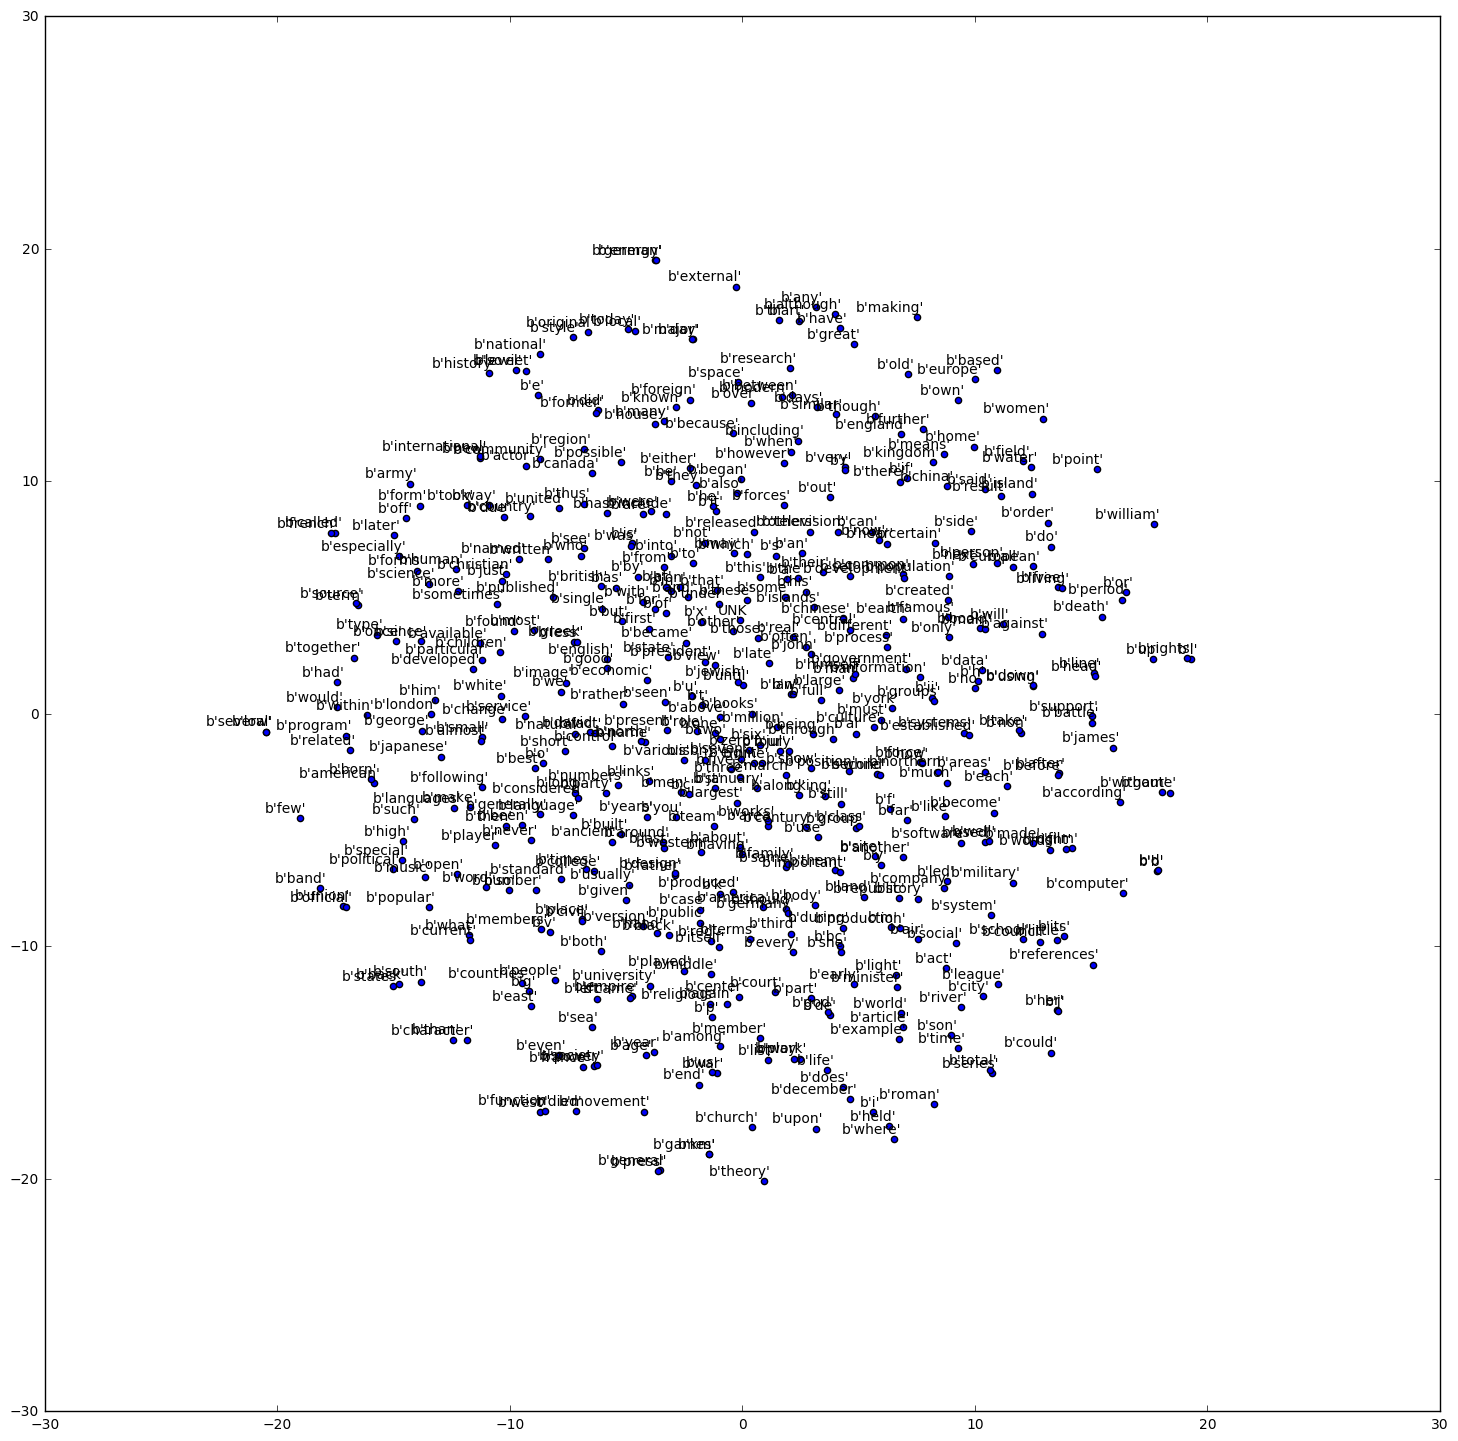

In [82]:
def  plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()
    
# Plot
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)